In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_34421/2809884579.py:45: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


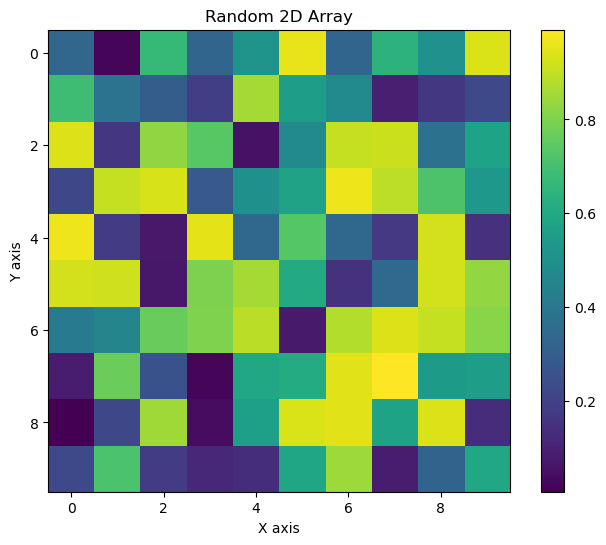

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
def my_snn_system(devices = "0,1,2,3",
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = True, 
                    dvs_duration = 1000000,

                    OTTT_sWS_on = True, # True # False
                  ):
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and convTrue_fcFalse == True


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    
    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    wandb.config.update(hyperparameters)
    wandb.run.name = f'sstep_lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
    wandb.define_metric("summary_val_acc", summary="max")
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    torch.manual_seed(my_seed)
    ###################################################################################################################################


    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration)
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            # elif (in_channel == 'M'): #it's a holy FC layer!
            #     img_size = img_size // 2
            else:
                print('past_in_channel', past_in_channel)
                print('bias_param', bias_param)
                print('in_channel', in_channel)
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if pre_trained == False:
        # if (convTrue_fcFalse == False):
        #     net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
        #              synapse_fc_trace_const1, synapse_fc_trace_const2, 
        #              lif_layer_v_init, lif_layer_v_decay, 
        #              lif_layer_v_threshold, lif_layer_v_reset,
        #              lif_layer_sg_width,
        #              tdBN_on,
        #              BN_on, TIME,
        #              surrogate,
        #              BPTT_on).to(device)
        # else:
        #     net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
        #              synapse_conv_kernel_size, synapse_conv_stride, 
        #              synapse_conv_padding, synapse_conv_trace_const1, 
        #              synapse_conv_trace_const2, 
        #              lif_layer_v_init, lif_layer_v_decay, 
        #              lif_layer_v_threshold, lif_layer_v_reset,
        #              lif_layer_sg_width,
        #              synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
        #              tdBN_on,
        #              BN_on, TIME,
        #              surrogate,
        #              BPTT_on,
        #              OTTT_sWS_on).to(device)
        
        # if (nda_net == True):
        #     net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
        #               lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
        #     net.T = TIME
        net = MY_SNN_CONV_ottt_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                     synapse_conv_kernel_size, synapse_conv_stride, 
                     synapse_conv_padding, synapse_conv_trace_const1, 
                     synapse_conv_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on,
                     OTTT_sWS_on).to(device)
        net = torch.nn.DataParallel(net) #나중에풀어줘
    else:
        net = torch.load(pre_trained_path)

    net = net.to(device)
    if (net_print == True):
        print(net)        
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    if (weight_count_print == True):
        for name, param in net.named_parameters():
            if param.requires_grad:
                print(f'Layer: {name} | Number of parameters: {param.numel()}')
    # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
    # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
    print('='*50)
    print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
    memory = params_num / 8 / 1024 / 1024 # MB
    precision = 32
    memory = memory * precision 
    print(f"Memory: {memory:.2f}MiB at {precision}-bit")
    print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])
    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        print('EPOCH', epoch)
        epoch_start_time = time.time()
        running_loss = 0.0

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if (ddp_on == True):
            if torch.distributed.get_rank() == 0:   
                iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        else:
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(iterator)):
            validation_interval2 = len(iterator)
        ##################################################################################################



        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()
            # print('inputs',inputs.size(),'\nlabels',labels.size())
                    
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                

                
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH)
            # ######################################################################################################


            labels = labels.repeat(TIME, 1)
            
            ## device로 보내주기 ######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            ###########################################################



            
            x_seq = inputs
            target_seq = labels
            # [T, B, ...]

            T = x_seq.shape[0]

            batch_loss = 0.
            y_all = []
            optimizer.zero_grad()
            for t in range(T):
                y_t = net(x_seq[t])
                # print('y_t',y_t.size())#[128, 10])
                # print('target_seq[t]',target_seq[t].size())#([1, 1, 1, 128])
                loss = criterion(y_t, target_seq[t].contiguous())
                loss.backward()
                batch_loss += loss.data
                y_all.append(y_t.detach())
            optimizer.step()
            # y_all: [B, T, ...]
            outputs_all = torch.stack(y_all, dim=1)
            mean_out = outputs_all.mean(1) # ottt꺼 쓸때
            # mean_out = outputs_all #내꺼쓸때
            outputs = mean_out
            iter_loss = batch_loss



            batch = BATCH 
            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            assert predicted.size(0) == labels[0].size(0), 'batch값 안맞노'
            total = labels.size(1)
            correct = (predicted == labels[0]).sum().item()
            tr_total += total
            tr_correct += correct
            iter_acc = correct / total
            if i % verbose_interval == verbose_interval-1:
                print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'{epoch}-{i}/{len(train_loader)} iter_acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            
            

            ### gradinet verbose ##########################################
            if (gradient_verbose == True):
                if (i % verbose_interval == verbose_interval-1):
                    print('\n\nepoch', epoch, 'iter', i)
                    for name, param in net.named_parameters():
                        if param.requires_grad:
                            print('\n\n\n\n' , name, param.grad)
            ################################################################
            


            running_loss += iter_loss.item()
            # print("Epoch: {}, Iter: {}, Loss: {}".format(epoch + 1, i + 1, running_loss / 100))

            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                correct = 0
                total = 0
                val_loss = 0.
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        inputs, labels = data
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        # inputs, labels = torch.autograd.Variable(inputs), torch.autograd.Variable(labels)
                        outputs_all=[]
                        for tt in range(TIME):
                            # compute output
                            outputs = net(inputs)
                            loss = criterion(outputs, labels)
                            outputs_all.append(outputs.detach())
                            val_loss += loss.data
                        outputs_all = torch.stack(outputs_all, dim=1)
                        mean_out = outputs_all.mean(1)
                        assert mean_out.size(0) == labels.size(0), 'batch값 안맞노'
                        _, predicted = torch.max(mean_out.data, 1)
                        correct += (predicted == labels).sum().item()
                        total += labels.size(0)
                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    # torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                    # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                    # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                    # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
            ####################################################################################################################################################
            iterator.set_description(f"iter_acc: {iter_acc_string}, iter_loss: {iter_loss}, val_acc: {100 * val_acc_now:.2f}%")  
            wandb.log({"iter_acc": iter_acc}, step=i+epoch*len(train_loader))
            wandb.log({"tr_acc": tr_acc}, step=i+epoch*len(train_loader))
            wandb.log({"val_acc_now": val_acc_now}, step=i+epoch*len(train_loader))
            wandb.log({"summary_val_acc": val_acc_now})
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### 모듈 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # np.save(iter_acc_file_name_time, iter_acc_array)
            # np.save(tr_acc_file_name_time, iter_acc_array)
            # np.save(val_acc_file_name_time, val_acc_now_array)
            # with open(hyperparameters_file_name_time, 'w') as f:
            #     json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## 모듈 세이브 ###########################################################################################
            # np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
            # np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
            # np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
            # with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
            #     json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [5]:
### my_snn control board ########################
decay = 0.5 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5

unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
wandb.init(project= f'my_snn {unique_name}')
my_snn_system(  devices = "4",
                unique_name = unique_name,
                my_seed = 42,
                TIME = 6 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = 128, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 32, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = 'CIFAR10',
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE','DVS_CIFAR10_2','NMNIST','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False

                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1,
                synapse_conv_trace_const2 = decay, # lif_layer_v_decay

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1,
                synapse_fc_trace_const2 = decay, # lif_layer_v_decay

                pre_trained = False, # True # False
                convTrue_fcFalse = True, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64],
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], #ottt
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_{unique_name}.pth",
                learning_rate = 0.1, # default 0.001  # ottt 0.1 0.00001 # nda 0.001 
                epoch_num = 300,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval = 999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = 'sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = True, # dvs zero&one  # gesture, cifar-dvs2, nmnist, ncaltech101
                dvs_duration = 1000000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                #있는 데이터들 #gesture 1000000 #nmnist 10000

                OTTT_sWS_on = True, # True # False # BPTT끄고, CONV에만 적용됨.
                
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling
# 이 낫다. 
 
# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


Files already downloaded and verified
Files already downloaded and verified
DataParallel(
  (module): MY_SNN_CONV_ottt_sstep(
    (layers): OTTTSequential(
      (0): SYNAPSE_CONV_trace_sstep()
      (1): LIF_layer_trace_sstep()
      (2): Scale()
      (3): SYNAPSE_CONV_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Scale()
      (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (7): SYNAPSE_CONV_trace_sstep()
      (8): LIF_layer_trace_sstep()
      (9): Scale()
      (10): SYNAPSE_CONV_trace_sstep()
      (11): LIF_layer_trace_sstep()
      (12): Scale()
      (13): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (14): SYNAPSE_CONV_trace_sstep()
      (15): LIF_layer_trace_sstep()
      (16): Scale()
      (17): SYNAPSE_CONV_trace_sstep()
      (18): LIF_layer_trace_sstep()
      (19): Scale()
      (20): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (21): SYNAPSE_CONV_trace_sstep()
      (22): LIF_layer_trace_sstep()
      (23): Scale()
      (24): SYN

iter_acc: 0-390/391 iter_acc: 53.75%, lr=['0.1'], iter_loss: 0.20271937549114227, val_acc: 52.18%: 100%|██████████| 391/391 [02:45<00:00,  2.36it/s]

epoch_time: 165.85294699668884 seconds

EPOCH 1



iter_acc: 1-390/391 iter_acc: 58.75%, lr=['0.09999725846827562'], iter_loss: 0.16128948330879211, val_acc: 62.77%: 100%|██████████| 391/391 [02:46<00:00,  2.34it/s]

epoch_time: 167.1051094532013 seconds

EPOCH 2



iter_acc: 2-390/391 iter_acc: 56.25%, lr=['0.09998903417374229'], iter_loss: 0.14838838577270508, val_acc: 70.47%: 100%|██████████| 391/391 [02:47<00:00,  2.34it/s]

epoch_time: 167.38360404968262 seconds

EPOCH 3



iter_acc: 3-390/391 iter_acc: 68.75%, lr=['0.0999753280182866'], iter_loss: 0.123636394739151, val_acc: 73.20%: 100%|██████████| 391/391 [02:47<00:00,  2.33it/s]  

epoch_time: 167.75313186645508 seconds

EPOCH 4



iter_acc: 4-390/391 iter_acc: 72.50%, lr=['0.09995614150494293'], iter_loss: 0.11210295557975769, val_acc: 75.12%: 100%|██████████| 391/391 [02:46<00:00,  2.35it/s]

epoch_time: 166.79488277435303 seconds

EPOCH 5



iter_acc: 5-390/391 iter_acc: 77.50%, lr=['0.0999314767377287'], iter_loss: 0.138490229845047, val_acc: 77.57%: 100%|██████████| 391/391 [02:46<00:00,  2.35it/s]  

epoch_time: 166.46551966667175 seconds

EPOCH 6



iter_acc: 6-390/391 iter_acc: 75.00%, lr=['0.09990133642141359'], iter_loss: 0.09949815273284912, val_acc: 79.68%: 100%|██████████| 391/391 [02:46<00:00,  2.35it/s]

epoch_time: 166.36524629592896 seconds

EPOCH 7



iter_acc: 7-390/391 iter_acc: 85.00%, lr=['0.0998657238612229'], iter_loss: 0.09378600120544434, val_acc: 81.01%: 100%|██████████| 391/391 [02:46<00:00,  2.35it/s]

epoch_time: 166.5862877368927 seconds

EPOCH 8



iter_acc: 8-390/391 iter_acc: 76.25%, lr=['0.09982464296247523'], iter_loss: 0.0874921977519989, val_acc: 82.38%: 100%|██████████| 391/391 [02:46<00:00,  2.35it/s] 

epoch_time: 166.68732213974 seconds

EPOCH 9



iter_acc: 9-390/391 iter_acc: 75.00%, lr=['0.099778098230154'], iter_loss: 0.09165503084659576, val_acc: 82.25%: 100%|██████████| 391/391 [02:46<00:00,  2.35it/s]

epoch_time: 166.63118433952332 seconds

EPOCH 10



iter_acc: 10-390/391 iter_acc: 76.25%, lr=['0.09972609476841367'], iter_loss: 0.08738318085670471, val_acc: 83.51%: 100%|██████████| 391/391 [02:46<00:00,  2.35it/s]

epoch_time: 166.51780462265015 seconds

EPOCH 11



iter_acc: 11-390/391 iter_acc: 83.75%, lr=['0.09966863828001983'], iter_loss: 0.08038775622844696, val_acc: 83.18%: 100%|██████████| 391/391 [02:45<00:00,  2.36it/s]

epoch_time: 166.05530500411987 seconds

EPOCH 12



iter_acc: 12-390/391 iter_acc: 90.00%, lr=['0.09960573506572391'], iter_loss: 0.10134770721197128, val_acc: 85.17%: 100%|██████████| 391/391 [02:45<00:00,  2.36it/s]

epoch_time: 166.1170620918274 seconds

EPOCH 13



iter_acc: 13-390/391 iter_acc: 85.00%, lr=['0.09953739202357219'], iter_loss: 0.07633323222398758, val_acc: 86.48%: 100%|██████████| 391/391 [02:45<00:00,  2.36it/s]

epoch_time: 165.95155334472656 seconds

EPOCH 14



iter_acc: 14-390/391 iter_acc: 85.00%, lr=['0.09946361664814943'], iter_loss: 0.08094365149736404, val_acc: 85.63%: 100%|██████████| 391/391 [02:45<00:00,  2.36it/s]

epoch_time: 166.0152747631073 seconds

EPOCH 15



iter_acc: 15-390/391 iter_acc: 86.25%, lr=['0.0993844170297569'], iter_loss: 0.07762245088815689, val_acc: 86.55%: 100%|██████████| 391/391 [02:45<00:00,  2.36it/s]

epoch_time: 166.14057064056396 seconds

EPOCH 16



iter_acc: 16-390/391 iter_acc: 86.25%, lr=['0.09929980185352526'], iter_loss: 0.03989738970994949, val_acc: 87.09%: 100%|██████████| 391/391 [02:46<00:00,  2.35it/s] 

epoch_time: 166.24481916427612 seconds

EPOCH 17



iter_acc: 17-390/391 iter_acc: 93.75%, lr=['0.0992097803984621'], iter_loss: 0.05641348659992218, val_acc: 87.18%: 100%|██████████| 391/391 [02:46<00:00,  2.35it/s] 

epoch_time: 166.2625331878662 seconds

EPOCH 18



iter_acc: 18-390/391 iter_acc: 85.00%, lr=['0.09911436253643445'], iter_loss: 0.051210369914770126, val_acc: 88.02%: 100%|██████████| 391/391 [02:46<00:00,  2.35it/s]

epoch_time: 166.3329632282257 seconds

EPOCH 19



iter_acc: 19-390/391 iter_acc: 87.50%, lr=['0.09901355873108611'], iter_loss: 0.08131355792284012, val_acc: 87.54%: 100%|██████████| 391/391 [04:09<00:00,  1.56it/s] 

epoch_time: 250.04320859909058 seconds

EPOCH 20



iter_acc: 20-390/391 iter_acc: 85.00%, lr=['0.09890738003669029'], iter_loss: 0.047788843512535095, val_acc: 88.31%: 100%|██████████| 391/391 [05:10<00:00,  1.26it/s]

epoch_time: 310.9723539352417 seconds

EPOCH 21



iter_acc: 21-390/391 iter_acc: 87.50%, lr=['0.09879583809693737'], iter_loss: 0.0963856503367424, val_acc: 88.28%: 100%|██████████| 391/391 [05:37<00:00,  1.16it/s]  

epoch_time: 337.66192603111267 seconds

EPOCH 22



iter_acc: 22-390/391 iter_acc: 87.50%, lr=['0.09867894514365802'], iter_loss: 0.04464811086654663, val_acc: 88.45%: 100%|██████████| 391/391 [05:34<00:00,  1.17it/s] 

epoch_time: 334.62333488464355 seconds

EPOCH 23



iter_acc: 23-390/391 iter_acc: 83.75%, lr=['0.09855671399548181'], iter_loss: 0.09232102334499359, val_acc: 89.18%: 100%|██████████| 391/391 [05:35<00:00,  1.17it/s] 

epoch_time: 335.7503890991211 seconds

EPOCH 24



iter_acc: 24-390/391 iter_acc: 92.50%, lr=['0.09842915805643157'], iter_loss: 0.07140888273715973, val_acc: 89.30%: 100%|██████████| 391/391 [05:52<00:00,  1.11it/s] 

epoch_time: 352.6430892944336 seconds

EPOCH 25



iter_acc: 25-390/391 iter_acc: 92.50%, lr=['0.09829629131445343'], iter_loss: 0.04927695915102959, val_acc: 89.43%: 100%|██████████| 391/391 [05:36<00:00,  1.16it/s] 

epoch_time: 336.8861074447632 seconds

EPOCH 26



iter_acc: 26-390/391 iter_acc: 93.75%, lr=['0.09815812833988292'], iter_loss: 0.09548665583133698, val_acc: 89.99%: 100%|██████████| 391/391 [05:58<00:00,  1.09it/s] 

epoch_time: 358.8998041152954 seconds

EPOCH 27



iter_acc: 27-390/391 iter_acc: 90.00%, lr=['0.09801468428384717'], iter_loss: 0.08468236774206161, val_acc: 89.66%: 100%|██████████| 391/391 [05:45<00:00,  1.13it/s] 

epoch_time: 345.57879853248596 seconds

EPOCH 28



iter_acc: 28-390/391 iter_acc: 91.25%, lr=['0.09786597487660338'], iter_loss: 0.0870702713727951, val_acc: 90.20%: 100%|██████████| 391/391 [05:36<00:00,  1.16it/s]  

epoch_time: 336.87845611572266 seconds

EPOCH 29



iter_acc: 29-390/391 iter_acc: 90.00%, lr=['0.09771201642581387'], iter_loss: 0.0969071313738823, val_acc: 90.10%: 100%|██████████| 391/391 [05:33<00:00,  1.17it/s]  

epoch_time: 333.8457546234131 seconds

EPOCH 30



iter_acc: 30-390/391 iter_acc: 88.75%, lr=['0.09755282581475772'], iter_loss: 0.05438878387212753, val_acc: 90.24%: 100%|██████████| 391/391 [05:32<00:00,  1.17it/s] 

epoch_time: 333.06641387939453 seconds

EPOCH 31



iter_acc: 31-390/391 iter_acc: 93.75%, lr=['0.09738842050047931'], iter_loss: 0.05460074171423912, val_acc: 90.21%: 100%|██████████| 391/391 [08:22<00:00,  1.29s/it] 

epoch_time: 503.0653614997864 seconds

EPOCH 32



iter_acc: 32-390/391 iter_acc: 95.00%, lr=['0.09721881851187408'], iter_loss: 0.09481241554021835, val_acc: 90.35%: 100%|██████████| 391/391 [05:33<00:00,  1.17it/s] 

epoch_time: 333.7546525001526 seconds

EPOCH 33



iter_acc: 33-390/391 iter_acc: 97.50%, lr=['0.0970440384477113'], iter_loss: 0.06824751943349838, val_acc: 90.05%: 100%|██████████| 391/391 [05:35<00:00,  1.17it/s] 

epoch_time: 335.7372682094574 seconds

EPOCH 34



iter_acc: 34-390/391 iter_acc: 95.00%, lr=['0.0968640994745946'], iter_loss: 0.10928402841091156, val_acc: 90.18%: 100%|██████████| 391/391 [05:34<00:00,  1.17it/s] 

epoch_time: 334.7827959060669 seconds

EPOCH 35



iter_acc: 35-390/391 iter_acc: 91.25%, lr=['0.0966790213248601'], iter_loss: 0.06643417477607727, val_acc: 90.54%: 100%|██████████| 391/391 [05:34<00:00,  1.17it/s] 

epoch_time: 334.7584562301636 seconds

EPOCH 36



iter_acc: 36-390/391 iter_acc: 90.00%, lr=['0.09648882429441259'], iter_loss: 0.07448634505271912, val_acc: 90.68%: 100%|██████████| 391/391 [05:36<00:00,  1.16it/s]  

epoch_time: 336.2856283187866 seconds

EPOCH 37



iter_acc: 37-390/391 iter_acc: 95.00%, lr=['0.09629352924049978'], iter_loss: 0.06724071502685547, val_acc: 90.46%: 100%|██████████| 391/391 [05:37<00:00,  1.16it/s] 

epoch_time: 337.4012007713318 seconds

EPOCH 38



iter_acc: 38-390/391 iter_acc: 93.75%, lr=['0.09609315757942506'], iter_loss: 0.055428143590688705, val_acc: 90.75%: 100%|██████████| 391/391 [05:36<00:00,  1.16it/s]

epoch_time: 336.28846049308777 seconds

EPOCH 39



iter_acc: 39-390/391 iter_acc: 96.25%, lr=['0.09588773128419908'], iter_loss: 0.0678824931383133, val_acc: 90.79%: 100%|██████████| 391/391 [05:36<00:00,  1.16it/s]  

epoch_time: 336.57090854644775 seconds

EPOCH 40



iter_acc: 40-390/391 iter_acc: 98.75%, lr=['0.09567727288213007'], iter_loss: 0.060196951031684875, val_acc: 91.27%: 100%|██████████| 391/391 [05:38<00:00,  1.15it/s]

epoch_time: 339.04157733917236 seconds

EPOCH 41



iter_acc: 41-390/391 iter_acc: 96.25%, lr=['0.09546180545235346'], iter_loss: 0.057455625385046005, val_acc: 91.30%: 100%|██████████| 391/391 [05:40<00:00,  1.15it/s]

epoch_time: 340.43404388427734 seconds

EPOCH 42



iter_acc: 42-390/391 iter_acc: 91.25%, lr=['0.09524135262330101'], iter_loss: 0.06223241984844208, val_acc: 91.55%: 100%|██████████| 391/391 [06:03<00:00,  1.07it/s]  

epoch_time: 363.97939896583557 seconds

EPOCH 43



iter_acc: 43-390/391 iter_acc: 95.00%, lr=['0.09501593857010972'], iter_loss: 0.06547868251800537, val_acc: 90.95%: 100%|██████████| 391/391 [05:43<00:00,  1.14it/s] 

epoch_time: 344.0053927898407 seconds

EPOCH 44



iter_acc: 44-390/391 iter_acc: 95.00%, lr=['0.09478558801197068'], iter_loss: 0.052959129214286804, val_acc: 90.91%: 100%|██████████| 391/391 [05:36<00:00,  1.16it/s] 

epoch_time: 336.64978098869324 seconds

EPOCH 45



iter_acc: 45-390/391 iter_acc: 92.50%, lr=['0.09455032620941842'], iter_loss: 0.0506819412112236, val_acc: 91.67%: 100%|██████████| 391/391 [05:35<00:00,  1.16it/s]  

epoch_time: 336.1085932254791 seconds

EPOCH 46



iter_acc: 46-390/391 iter_acc: 93.75%, lr=['0.09431017896156076'], iter_loss: 0.0641709417104721, val_acc: 90.98%: 100%|██████████| 391/391 [05:39<00:00,  1.15it/s]  

epoch_time: 339.82754611968994 seconds

EPOCH 47



iter_acc: 47-390/391 iter_acc: 96.25%, lr=['0.09406517260324962'], iter_loss: 0.059738531708717346, val_acc: 91.34%: 100%|██████████| 391/391 [05:32<00:00,  1.18it/s]

epoch_time: 332.5788404941559 seconds

EPOCH 48



iter_acc: 48-390/391 iter_acc: 92.50%, lr=['0.09381533400219319'], iter_loss: 0.045493029057979584, val_acc: 91.30%: 100%|██████████| 391/391 [05:33<00:00,  1.17it/s]

epoch_time: 333.94280219078064 seconds

EPOCH 49



iter_acc: 49-390/391 iter_acc: 97.50%, lr=['0.09356069055600949'], iter_loss: 0.07089735567569733, val_acc: 91.60%: 100%|██████████| 391/391 [05:33<00:00,  1.17it/s] 

epoch_time: 333.2234377861023 seconds

EPOCH 50



iter_acc: 50-390/391 iter_acc: 96.25%, lr=['0.09330127018922195'], iter_loss: 0.047413915395736694, val_acc: 91.47%: 100%|██████████| 391/391 [05:33<00:00,  1.17it/s]

epoch_time: 334.0057485103607 seconds

EPOCH 51



iter_acc: 51-390/391 iter_acc: 97.50%, lr=['0.0930371013501972'], iter_loss: 0.05175086110830307, val_acc: 91.53%: 100%|██████████| 391/391 [05:38<00:00,  1.16it/s] 

epoch_time: 338.461918592453 seconds

EPOCH 52



iter_acc: 52-390/391 iter_acc: 97.50%, lr=['0.09276821300802535'], iter_loss: 0.05372605845332146, val_acc: 91.85%: 100%|██████████| 391/391 [05:34<00:00,  1.17it/s]  

epoch_time: 334.2372000217438 seconds

EPOCH 53



iter_acc: 53-390/391 iter_acc: 97.50%, lr=['0.09249463464934321'], iter_loss: 0.066044881939888, val_acc: 91.57%: 100%|██████████| 391/391 [05:38<00:00,  1.16it/s]    

epoch_time: 338.3410015106201 seconds

EPOCH 54



iter_acc: 54-390/391 iter_acc: 97.50%, lr=['0.09221639627510077'], iter_loss: 0.08428411930799484, val_acc: 91.48%: 100%|██████████| 391/391 [05:36<00:00,  1.16it/s]  

epoch_time: 337.1303458213806 seconds

EPOCH 55



iter_acc: 55-390/391 iter_acc: 98.75%, lr=['0.09193352839727122'], iter_loss: 0.0805380791425705, val_acc: 91.87%: 100%|██████████| 391/391 [06:40<00:00,  1.02s/it]   

epoch_time: 400.23142170906067 seconds

EPOCH 56



iter_acc: 56-390/391 iter_acc: 98.75%, lr=['0.09164606203550499'], iter_loss: 0.056417226791381836, val_acc: 91.83%: 100%|██████████| 391/391 [07:10<00:00,  1.10s/it] 

epoch_time: 430.57886934280396 seconds

EPOCH 57



iter_acc: 57-390/391 iter_acc: 96.25%, lr=['0.0913540287137281'], iter_loss: 0.03223969042301178, val_acc: 91.76%: 100%|██████████| 391/391 [07:25<00:00,  1.14s/it]  

epoch_time: 446.07310485839844 seconds

EPOCH 58



iter_acc: 58-390/391 iter_acc: 97.50%, lr=['0.09105746045668521'], iter_loss: 0.04639507830142975, val_acc: 92.05%: 100%|██████████| 391/391 [07:04<00:00,  1.09s/it]  

epoch_time: 425.1403007507324 seconds

EPOCH 59



iter_acc: 59-390/391 iter_acc: 97.50%, lr=['0.09075638978642771'], iter_loss: 0.03627483546733856, val_acc: 91.98%: 100%|██████████| 391/391 [05:53<00:00,  1.11it/s]  

epoch_time: 353.7598469257355 seconds

EPOCH 60



iter_acc: 60-390/391 iter_acc: 98.75%, lr=['0.09045084971874738'], iter_loss: 0.04520750045776367, val_acc: 91.71%: 100%|██████████| 391/391 [05:48<00:00,  1.12it/s]  

epoch_time: 349.181031703949 seconds

EPOCH 61



iter_acc: 61-390/391 iter_acc: 98.75%, lr=['0.09014087375955573'], iter_loss: 0.07646109908819199, val_acc: 91.78%: 100%|██████████| 391/391 [06:15<00:00,  1.04it/s]  

epoch_time: 375.8929674625397 seconds

EPOCH 62



iter_acc: 62-390/391 iter_acc: 97.50%, lr=['0.08982649590120982'], iter_loss: 0.06838259100914001, val_acc: 91.83%: 100%|██████████| 391/391 [05:47<00:00,  1.13it/s]  

epoch_time: 347.301677942276 seconds

EPOCH 63



iter_acc: 63-390/391 iter_acc: 96.25%, lr=['0.08950775061878452'], iter_loss: 0.06253878027200699, val_acc: 91.84%: 100%|██████████| 391/391 [03:01<00:00,  2.15it/s]  

epoch_time: 182.08005785942078 seconds

EPOCH 64



iter_acc: 64-390/391 iter_acc: 100.00%, lr=['0.089184672866292'], iter_loss: 0.0608908012509346, val_acc: 92.26%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s] 

epoch_time: 173.55085158348083 seconds

EPOCH 65



iter_acc: 65-390/391 iter_acc: 95.00%, lr=['0.08885729807284856'], iter_loss: 0.0793195515871048, val_acc: 92.11%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s]   

epoch_time: 172.52640509605408 seconds

EPOCH 66



iter_acc: 66-390/391 iter_acc: 98.75%, lr=['0.08852566213878947'], iter_loss: 0.1170826181769371, val_acc: 91.75%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s]   

epoch_time: 172.01955461502075 seconds

EPOCH 67



iter_acc: 67-390/391 iter_acc: 98.75%, lr=['0.08818980143173213'], iter_loss: 0.07646772265434265, val_acc: 91.92%: 100%|██████████| 391/391 [02:52<00:00,  2.26it/s]  

epoch_time: 172.94969725608826 seconds

EPOCH 68



iter_acc: 68-390/391 iter_acc: 98.75%, lr=['0.08784975278258783'], iter_loss: 0.0920020043849945, val_acc: 91.61%: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s]   

epoch_time: 179.4976842403412 seconds

EPOCH 69



iter_acc: 69-390/391 iter_acc: 95.00%, lr=['0.08750555348152299'], iter_loss: 0.08974920213222504, val_acc: 91.89%: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s]  

epoch_time: 183.69127082824707 seconds

EPOCH 70



iter_acc: 70-390/391 iter_acc: 97.50%, lr=['0.08715724127386973'], iter_loss: 0.07134650647640228, val_acc: 92.39%: 100%|██████████| 391/391 [03:06<00:00,  2.09it/s]  

epoch_time: 186.82654237747192 seconds

EPOCH 71



iter_acc: 71-390/391 iter_acc: 97.50%, lr=['0.08680485435598673'], iter_loss: 0.06581759452819824, val_acc: 91.91%: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s]  

epoch_time: 190.94332146644592 seconds

EPOCH 72



iter_acc: 72-390/391 iter_acc: 98.75%, lr=['0.0864484313710706'], iter_loss: 0.07686404883861542, val_acc: 92.23%: 100%|██████████| 391/391 [03:02<00:00,  2.14it/s]  

epoch_time: 182.89419841766357 seconds

EPOCH 73



iter_acc: 73-390/391 iter_acc: 95.00%, lr=['0.08608801140491813'], iter_loss: 0.054704245179891586, val_acc: 92.06%: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s] 

epoch_time: 190.77774286270142 seconds

EPOCH 74



iter_acc: 74-390/391 iter_acc: 100.00%, lr=['0.0857236339816402'], iter_loss: 0.08268308639526367, val_acc: 91.75%: 100%|██████████| 391/391 [03:03<00:00,  2.14it/s] 

epoch_time: 183.23480033874512 seconds

EPOCH 75



iter_acc: 75-390/391 iter_acc: 95.00%, lr=['0.0853553390593274'], iter_loss: 0.0850263237953186, val_acc: 92.09%: 100%|██████████| 391/391 [03:09<00:00,  2.06it/s]   

epoch_time: 190.002347946167 seconds

EPOCH 76



iter_acc: 76-390/391 iter_acc: 100.00%, lr=['0.08498316702566831'], iter_loss: 0.07182307541370392, val_acc: 92.31%: 100%|██████████| 391/391 [03:07<00:00,  2.09it/s] 

epoch_time: 187.3332977294922 seconds

EPOCH 77



iter_acc: 77-390/391 iter_acc: 96.25%, lr=['0.08460715869352037'], iter_loss: 0.06006304547190666, val_acc: 92.19%: 100%|██████████| 391/391 [03:15<00:00,  1.99it/s]  

epoch_time: 196.15922212600708 seconds

EPOCH 78



iter_acc: 78-390/391 iter_acc: 96.25%, lr=['0.08422735529643446'], iter_loss: 0.056349389255046844, val_acc: 92.22%: 100%|██████████| 391/391 [03:05<00:00,  2.11it/s] 

epoch_time: 185.50058507919312 seconds

EPOCH 79



iter_acc: 79-390/391 iter_acc: 95.00%, lr=['0.08384379848413306'], iter_loss: 0.05347621068358421, val_acc: 92.70%: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s]  

epoch_time: 184.9782452583313 seconds

EPOCH 80



iter_acc: 80-390/391 iter_acc: 98.75%, lr=['0.08345653031794294'], iter_loss: 0.06326190382242203, val_acc: 92.49%: 100%|██████████| 391/391 [03:11<00:00,  2.04it/s]  

epoch_time: 191.58631801605225 seconds

EPOCH 81



iter_acc: 81-390/391 iter_acc: 98.75%, lr=['0.08306559326618262'], iter_loss: 0.05111623927950859, val_acc: 92.77%: 100%|██████████| 391/391 [03:06<00:00,  2.09it/s]  

epoch_time: 187.14746856689453 seconds

EPOCH 82



iter_acc: 82-390/391 iter_acc: 98.75%, lr=['0.08267103019950531'], iter_loss: 0.0730670839548111, val_acc: 92.67%: 100%|██████████| 391/391 [03:05<00:00,  2.11it/s]   

epoch_time: 185.54850912094116 seconds

EPOCH 83



iter_acc: 83-390/391 iter_acc: 100.00%, lr=['0.08227288438619755'], iter_loss: 0.06322301924228668, val_acc: 92.50%: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s] 

epoch_time: 192.95448875427246 seconds

EPOCH 84



iter_acc: 84-390/391 iter_acc: 98.75%, lr=['0.0818711994874345'], iter_loss: 0.08142895996570587, val_acc: 92.40%: 100%|██████████| 391/391 [03:05<00:00,  2.10it/s]  

epoch_time: 186.06073927879333 seconds

EPOCH 85



iter_acc: 85-390/391 iter_acc: 100.00%, lr=['0.08146601955249189'], iter_loss: 0.07446631789207458, val_acc: 92.45%: 100%|██████████| 391/391 [03:08<00:00,  2.07it/s] 

epoch_time: 189.03555011749268 seconds

EPOCH 86



iter_acc: 86-390/391 iter_acc: 97.50%, lr=['0.08105738901391554'], iter_loss: 0.06364572048187256, val_acc: 92.39%: 100%|██████████| 391/391 [03:01<00:00,  2.16it/s]  

epoch_time: 181.45997095108032 seconds

EPOCH 87



iter_acc: 87-390/391 iter_acc: 100.00%, lr=['0.08064535268264884'], iter_loss: 0.0668475404381752, val_acc: 92.63%: 100%|██████████| 391/391 [02:59<00:00,  2.17it/s]  

epoch_time: 180.10221982002258 seconds

EPOCH 88



iter_acc: 88-390/391 iter_acc: 98.75%, lr=['0.08022995574311877'], iter_loss: 0.07167227566242218, val_acc: 92.47%: 100%|██████████| 391/391 [03:07<00:00,  2.08it/s]  

epoch_time: 188.1472990512848 seconds

EPOCH 89



iter_acc: 89-390/391 iter_acc: 100.00%, lr=['0.0798112437482808'], iter_loss: 0.07273127138614655, val_acc: 92.48%: 100%|██████████| 391/391 [03:05<00:00,  2.10it/s] 

epoch_time: 185.95852899551392 seconds

EPOCH 90



iter_acc: 90-390/391 iter_acc: 98.75%, lr=['0.07938926261462366'], iter_loss: 0.07114347815513611, val_acc: 92.49%: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s]  

epoch_time: 184.6448175907135 seconds

EPOCH 91



iter_acc: 91-390/391 iter_acc: 98.75%, lr=['0.07896405861713394'], iter_loss: 0.08514203131198883, val_acc: 92.53%: 100%|██████████| 391/391 [03:02<00:00,  2.14it/s]  

epoch_time: 182.4570186138153 seconds

EPOCH 92



iter_acc: 92-390/391 iter_acc: 100.00%, lr=['0.0785356783842216'], iter_loss: 0.06343479454517365, val_acc: 92.30%: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s] 

epoch_time: 184.55579018592834 seconds

EPOCH 93



iter_acc: 93-390/391 iter_acc: 96.25%, lr=['0.07810416889260655'], iter_loss: 0.0654517263174057, val_acc: 92.54%: 100%|██████████| 391/391 [03:09<00:00,  2.07it/s]   

epoch_time: 189.33884000778198 seconds

EPOCH 94



iter_acc: 94-390/391 iter_acc: 97.50%, lr=['0.07766957746216721'], iter_loss: 0.08015535771846771, val_acc: 92.18%: 100%|██████████| 391/391 [02:58<00:00,  2.19it/s]  

epoch_time: 178.79558038711548 seconds

EPOCH 95



iter_acc: 95-390/391 iter_acc: 98.75%, lr=['0.07723195175075136'], iter_loss: 0.08690836280584335, val_acc: 92.63%: 100%|██████████| 391/391 [03:05<00:00,  2.10it/s]  

epoch_time: 186.04628467559814 seconds

EPOCH 96



iter_acc: 96-390/391 iter_acc: 98.75%, lr=['0.07679133974894983'], iter_loss: 0.07082033902406693, val_acc: 92.70%: 100%|██████████| 391/391 [03:03<00:00,  2.14it/s]  

epoch_time: 183.17857837677002 seconds

EPOCH 97



iter_acc: 97-390/391 iter_acc: 100.00%, lr=['0.07634778977483389'], iter_loss: 0.07546528428792953, val_acc: 92.86%: 100%|██████████| 391/391 [03:42<00:00,  1.75it/s] 

epoch_time: 222.9920802116394 seconds

EPOCH 98



iter_acc: 98-390/391 iter_acc: 98.75%, lr=['0.07590135046865652'], iter_loss: 0.08926381915807724, val_acc: 92.42%: 100%|██████████| 391/391 [04:31<00:00,  1.44it/s]  

epoch_time: 271.17008876800537 seconds

EPOCH 99



iter_acc: 99-390/391 iter_acc: 98.75%, lr=['0.07545207078751857'], iter_loss: 0.07111167907714844, val_acc: 92.85%: 100%|██████████| 391/391 [04:24<00:00,  1.48it/s]  

epoch_time: 264.67336201667786 seconds

EPOCH 100



iter_acc: 100-390/391 iter_acc: 100.00%, lr=['0.07500000000000001'], iter_loss: 0.06648889183998108, val_acc: 92.80%: 100%|██████████| 391/391 [04:29<00:00,  1.45it/s] 

epoch_time: 269.2813608646393 seconds

EPOCH 101



iter_acc: 101-390/391 iter_acc: 96.25%, lr=['0.07454518768075706'], iter_loss: 0.04673479124903679, val_acc: 92.60%: 100%|██████████| 391/391 [04:12<00:00,  1.55it/s]  

epoch_time: 253.04325819015503 seconds

EPOCH 102



iter_acc: 102-390/391 iter_acc: 98.75%, lr=['0.07408768370508578'], iter_loss: 0.05202481150627136, val_acc: 92.39%: 100%|██████████| 391/391 [04:04<00:00,  1.60it/s]  

epoch_time: 244.718683719635 seconds

EPOCH 103



iter_acc: 103-390/391 iter_acc: 100.00%, lr=['0.07362753824345272'], iter_loss: 0.06555553525686264, val_acc: 92.80%: 100%|██████████| 391/391 [04:55<00:00,  1.32it/s] 

epoch_time: 295.48112654685974 seconds

EPOCH 104



iter_acc: 104-390/391 iter_acc: 100.00%, lr=['0.07316480175599312'], iter_loss: 0.070918008685112, val_acc: 92.55%: 100%|██████████| 391/391 [04:20<00:00,  1.50it/s]   

epoch_time: 261.06430864334106 seconds

EPOCH 105



iter_acc: 105-390/391 iter_acc: 96.25%, lr=['0.07269952498697736'], iter_loss: 0.06120341271162033, val_acc: 92.91%: 100%|██████████| 391/391 [04:48<00:00,  1.36it/s]  

epoch_time: 288.27136969566345 seconds

EPOCH 106



iter_acc: 106-390/391 iter_acc: 98.75%, lr=['0.0722317589592464'], iter_loss: 0.0954306349158287, val_acc: 92.57%: 100%|██████████| 391/391 [04:25<00:00,  1.47it/s]   

epoch_time: 265.3496389389038 seconds

EPOCH 107



iter_acc: 107-390/391 iter_acc: 95.00%, lr=['0.0717615549686164'], iter_loss: 0.07867003232240677, val_acc: 92.86%: 100%|██████████| 391/391 [03:58<00:00,  1.64it/s]  

epoch_time: 238.53412985801697 seconds

EPOCH 108



iter_acc: 108-390/391 iter_acc: 98.75%, lr=['0.07128896457825365'], iter_loss: 0.08213415741920471, val_acc: 92.74%: 100%|██████████| 391/391 [04:15<00:00,  1.53it/s]  

epoch_time: 256.10326385498047 seconds

EPOCH 109



iter_acc: 109-390/391 iter_acc: 98.75%, lr=['0.07081403961302007'], iter_loss: 0.08289126306772232, val_acc: 92.78%: 100%|██████████| 391/391 [03:58<00:00,  1.64it/s]  

epoch_time: 238.44110941886902 seconds

EPOCH 110



iter_acc: 110-390/391 iter_acc: 97.50%, lr=['0.07033683215379001'], iter_loss: 0.08583901822566986, val_acc: 92.68%: 100%|██████████| 391/391 [04:33<00:00,  1.43it/s]  

epoch_time: 273.7182035446167 seconds

EPOCH 111



iter_acc: 111-390/391 iter_acc: 98.75%, lr=['0.06985739453173903'], iter_loss: 0.07954002916812897, val_acc: 92.60%: 100%|██████████| 391/391 [04:27<00:00,  1.46it/s]  

epoch_time: 267.8036630153656 seconds

EPOCH 112



iter_acc: 112-390/391 iter_acc: 98.75%, lr=['0.06937577932260515'], iter_loss: 0.08317402005195618, val_acc: 92.80%: 100%|██████████| 391/391 [04:28<00:00,  1.46it/s]  

epoch_time: 268.33908677101135 seconds

EPOCH 113



iter_acc: 113-390/391 iter_acc: 98.75%, lr=['0.06889203934092336'], iter_loss: 0.060238614678382874, val_acc: 92.63%: 100%|██████████| 391/391 [04:02<00:00,  1.61it/s] 

epoch_time: 242.40636134147644 seconds

EPOCH 114



iter_acc: 114-390/391 iter_acc: 100.00%, lr=['0.0684062276342339'], iter_loss: 0.08377190679311752, val_acc: 92.93%: 100%|██████████| 391/391 [04:04<00:00,  1.60it/s] 

epoch_time: 244.59247875213623 seconds

EPOCH 115



iter_acc: 115-390/391 iter_acc: 97.50%, lr=['0.067918397477265'], iter_loss: 0.07574519515037537, val_acc: 92.85%: 100%|██████████| 391/391 [04:21<00:00,  1.49it/s]  

epoch_time: 261.9405629634857 seconds

EPOCH 116



iter_acc: 116-390/391 iter_acc: 97.50%, lr=['0.06742860236609076'], iter_loss: 0.054166462272405624, val_acc: 92.71%: 100%|██████████| 391/391 [03:01<00:00,  2.15it/s] 

epoch_time: 181.6657178401947 seconds

EPOCH 117



iter_acc: 117-390/391 iter_acc: 98.75%, lr=['0.06693689601226457'], iter_loss: 0.0527227446436882, val_acc: 92.92%: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]   

epoch_time: 192.48615956306458 seconds

EPOCH 118



iter_acc: 118-390/391 iter_acc: 97.50%, lr=['0.06644333233692916'], iter_loss: 0.06919519603252411, val_acc: 92.58%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]  

epoch_time: 198.71852850914001 seconds

EPOCH 119



iter_acc: 119-390/391 iter_acc: 100.00%, lr=['0.0659479654649035'], iter_loss: 0.07478819787502289, val_acc: 92.91%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s] 

epoch_time: 212.57184314727783 seconds

EPOCH 120



iter_acc: 120-390/391 iter_acc: 97.50%, lr=['0.06545084971874737'], iter_loss: 0.03965616971254349, val_acc: 92.92%: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s]  

epoch_time: 190.80935072898865 seconds

EPOCH 121



iter_acc: 121-390/391 iter_acc: 100.00%, lr=['0.06495203961280434'], iter_loss: 0.0618298202753067, val_acc: 92.90%: 100%|██████████| 391/391 [03:25<00:00,  1.91it/s]  

epoch_time: 205.34323048591614 seconds

EPOCH 122



iter_acc: 122-390/391 iter_acc: 100.00%, lr=['0.06445158984722359'], iter_loss: 0.07066060602664948, val_acc: 93.04%: 100%|██████████| 391/391 [03:23<00:00,  1.92it/s] 

epoch_time: 203.38041067123413 seconds

EPOCH 123



iter_acc: 123-390/391 iter_acc: 97.50%, lr=['0.06394955530196147'], iter_loss: 0.0768471211194992, val_acc: 92.89%: 100%|██████████| 391/391 [03:23<00:00,  1.92it/s]   

epoch_time: 203.74215698242188 seconds

EPOCH 124



iter_acc: 124-390/391 iter_acc: 98.75%, lr=['0.06344599103076329'], iter_loss: 0.07395973056554794, val_acc: 93.23%: 100%|██████████| 391/391 [03:24<00:00,  1.91it/s]  

epoch_time: 204.63810682296753 seconds

EPOCH 125



iter_acc: 125-390/391 iter_acc: 98.75%, lr=['0.06294095225512605'], iter_loss: 0.07408150285482407, val_acc: 93.02%: 100%|██████████| 391/391 [03:05<00:00,  2.11it/s]  

epoch_time: 185.336275100708 seconds

EPOCH 126



iter_acc: 126-390/391 iter_acc: 96.25%, lr=['0.062434494358242734'], iter_loss: 0.051526736468076706, val_acc: 92.95%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s] 

epoch_time: 199.11284685134888 seconds

EPOCH 127



iter_acc: 127-390/391 iter_acc: 98.75%, lr=['0.06192667287892904'], iter_loss: 0.05166187882423401, val_acc: 93.04%: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s]  

epoch_time: 183.95278429985046 seconds

EPOCH 128



iter_acc: 128-390/391 iter_acc: 98.75%, lr=['0.06141754350553279'], iter_loss: 0.06614068150520325, val_acc: 93.18%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]  

epoch_time: 198.94629836082458 seconds

EPOCH 129



iter_acc: 129-390/391 iter_acc: 100.00%, lr=['0.06090716206982714'], iter_loss: 0.06968049705028534, val_acc: 92.85%: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s] 

epoch_time: 183.67621064186096 seconds

EPOCH 130



iter_acc: 130-390/391 iter_acc: 98.75%, lr=['0.06039558454088797'], iter_loss: 0.06098306179046631, val_acc: 92.89%: 100%|██████████| 391/391 [03:17<00:00,  1.97it/s]  

epoch_time: 198.14243006706238 seconds

EPOCH 131



iter_acc: 131-390/391 iter_acc: 100.00%, lr=['0.059882867018956294'], iter_loss: 0.06626282632350922, val_acc: 92.90%: 100%|██████████| 391/391 [03:23<00:00,  1.92it/s] 

epoch_time: 203.61396050453186 seconds

EPOCH 132



iter_acc: 132-390/391 iter_acc: 100.00%, lr=['0.05936906572928624'], iter_loss: 0.0681789368391037, val_acc: 92.97%: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s]  

epoch_time: 183.78239822387695 seconds

EPOCH 133



iter_acc: 133-390/391 iter_acc: 98.75%, lr=['0.05885423701597917'], iter_loss: 0.06286496669054031, val_acc: 92.98%: 100%|██████████| 391/391 [03:00<00:00,  2.16it/s]  

epoch_time: 180.9446427822113 seconds

EPOCH 134



iter_acc: 134-390/391 iter_acc: 100.00%, lr=['0.05833843733580512'], iter_loss: 0.07837945222854614, val_acc: 92.75%: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s] 

epoch_time: 186.38310885429382 seconds

EPOCH 135



iter_acc: 135-390/391 iter_acc: 97.50%, lr=['0.057821723252011556'], iter_loss: 0.04663979634642601, val_acc: 92.77%: 100%|██████████| 391/391 [03:28<00:00,  1.87it/s]  

epoch_time: 209.00745177268982 seconds

EPOCH 136



iter_acc: 136-390/391 iter_acc: 98.75%, lr=['0.0573041514281206'], iter_loss: 0.06858669966459274, val_acc: 92.90%: 100%|██████████| 391/391 [03:57<00:00,  1.65it/s]  

epoch_time: 237.2894730567932 seconds

EPOCH 137



iter_acc: 137-390/391 iter_acc: 97.50%, lr=['0.05678577862171523'], iter_loss: 0.06795690953731537, val_acc: 92.83%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s]  

epoch_time: 176.53119659423828 seconds

EPOCH 138



iter_acc: 138-390/391 iter_acc: 97.50%, lr=['0.05626666167821522'], iter_loss: 0.06625421345233917, val_acc: 92.87%: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s]  

epoch_time: 190.5065562725067 seconds

EPOCH 139



iter_acc: 139-390/391 iter_acc: 97.50%, lr=['0.055746857524643346'], iter_loss: 0.05609370023012161, val_acc: 92.85%: 100%|██████████| 391/391 [03:11<00:00,  2.04it/s]  

epoch_time: 191.90766787528992 seconds

EPOCH 140



iter_acc: 140-390/391 iter_acc: 100.00%, lr=['0.0552264231633827'], iter_loss: 0.06877221912145615, val_acc: 93.05%: 100%|██████████| 391/391 [04:04<00:00,  1.60it/s] 

epoch_time: 245.03791975975037 seconds

EPOCH 141



iter_acc: 141-390/391 iter_acc: 100.00%, lr=['0.05470541566592574'], iter_loss: 0.07835152745246887, val_acc: 92.92%: 100%|██████████| 391/391 [03:51<00:00,  1.69it/s] 

epoch_time: 232.04130339622498 seconds

EPOCH 142



iter_acc: 142-390/391 iter_acc: 100.00%, lr=['0.05418389216661579'], iter_loss: 0.06763628125190735, val_acc: 93.20%: 100%|██████████| 391/391 [03:00<00:00,  2.17it/s] 

epoch_time: 180.43345737457275 seconds

EPOCH 143



iter_acc: 143-390/391 iter_acc: 97.50%, lr=['0.0536619098563816'], iter_loss: 0.07801172137260437, val_acc: 92.99%: 100%|██████████| 391/391 [04:09<00:00,  1.57it/s]  

epoch_time: 249.65091061592102 seconds

EPOCH 144



iter_acc: 144-390/391 iter_acc: 95.00%, lr=['0.053139525976465686'], iter_loss: 0.07278017699718475, val_acc: 93.10%: 100%|██████████| 391/391 [03:54<00:00,  1.67it/s]  

epoch_time: 234.97406435012817 seconds

EPOCH 145



iter_acc: 145-390/391 iter_acc: 96.25%, lr=['0.05261679781214721'], iter_loss: 0.08218857645988464, val_acc: 92.79%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]  

epoch_time: 198.83010935783386 seconds

EPOCH 146



iter_acc: 146-390/391 iter_acc: 97.50%, lr=['0.05209378268646'], iter_loss: 0.07786638289690018, val_acc: 93.15%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]  

epoch_time: 175.5768060684204 seconds

EPOCH 147



iter_acc: 147-390/391 iter_acc: 98.75%, lr=['0.05157053795390641'], iter_loss: 0.07736142724752426, val_acc: 92.93%: 100%|██████████| 391/391 [03:09<00:00,  2.06it/s]  

epoch_time: 189.54422998428345 seconds

EPOCH 148



iter_acc: 148-390/391 iter_acc: 98.75%, lr=['0.051047120994167854'], iter_loss: 0.057531245052814484, val_acc: 92.91%: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s] 

epoch_time: 190.59957647323608 seconds

EPOCH 149



iter_acc: 149-390/391 iter_acc: 98.75%, lr=['0.0505235892058123'], iter_loss: 0.07355090230703354, val_acc: 93.03%: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s]  

epoch_time: 183.7576460838318 seconds

EPOCH 150



iter_acc: 150-390/391 iter_acc: 100.00%, lr=['0.05000000000000001'], iter_loss: 0.05331965908408165, val_acc: 93.04%: 100%|██████████| 391/391 [03:02<00:00,  2.14it/s] 

epoch_time: 182.8736002445221 seconds

EPOCH 151



iter_acc: 151-390/391 iter_acc: 100.00%, lr=['0.04947641079418772'], iter_loss: 0.05642380565404892, val_acc: 93.25%: 100%|██████████| 391/391 [03:00<00:00,  2.16it/s] 

epoch_time: 181.00664496421814 seconds

EPOCH 152



iter_acc: 152-390/391 iter_acc: 97.50%, lr=['0.04895287900583217'], iter_loss: 0.08303554356098175, val_acc: 93.05%: 100%|██████████| 391/391 [03:01<00:00,  2.15it/s]  

epoch_time: 182.1704864501953 seconds

EPOCH 153



iter_acc: 153-390/391 iter_acc: 98.75%, lr=['0.048429462046093594'], iter_loss: 0.07491525262594223, val_acc: 92.92%: 100%|██████████| 391/391 [03:01<00:00,  2.15it/s]  

epoch_time: 181.92177557945251 seconds

EPOCH 154



iter_acc: 154-390/391 iter_acc: 100.00%, lr=['0.04790621731354002'], iter_loss: 0.07885851711034775, val_acc: 93.00%: 100%|██████████| 391/391 [03:08<00:00,  2.07it/s] 

epoch_time: 188.67011713981628 seconds

EPOCH 155



iter_acc: 155-390/391 iter_acc: 100.00%, lr=['0.04738320218785281'], iter_loss: 0.06908340752124786, val_acc: 93.28%: 100%|██████████| 391/391 [03:02<00:00,  2.14it/s] 

epoch_time: 182.65792608261108 seconds

EPOCH 156



iter_acc: 156-390/391 iter_acc: 96.25%, lr=['0.04686047402353434'], iter_loss: 0.08510326594114304, val_acc: 93.15%: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s]  

epoch_time: 184.64831495285034 seconds

EPOCH 157



iter_acc: 157-390/391 iter_acc: 100.00%, lr=['0.04633809014361842'], iter_loss: 0.0704977735877037, val_acc: 93.01%: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s]  

epoch_time: 183.54316449165344 seconds

EPOCH 158



iter_acc: 158-390/391 iter_acc: 98.75%, lr=['0.04581610783338422'], iter_loss: 0.07853852212429047, val_acc: 92.87%: 100%|██████████| 391/391 [03:06<00:00,  2.09it/s]  

epoch_time: 187.10708928108215 seconds

EPOCH 159



iter_acc: 159-390/391 iter_acc: 97.50%, lr=['0.045294584334074274'], iter_loss: 0.06494107842445374, val_acc: 93.07%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s]  

epoch_time: 201.8302755355835 seconds

EPOCH 160



iter_acc: 160-390/391 iter_acc: 98.75%, lr=['0.044773576836617326'], iter_loss: 0.06249701604247093, val_acc: 93.25%: 100%|██████████| 391/391 [03:53<00:00,  1.68it/s]  

epoch_time: 233.59501934051514 seconds

EPOCH 161



iter_acc: 161-390/391 iter_acc: 97.50%, lr=['0.044253142475356666'], iter_loss: 0.087547168135643, val_acc: 93.25%: 100%|██████████| 391/391 [04:16<00:00,  1.52it/s]    

epoch_time: 257.134560585022 seconds

EPOCH 162



iter_acc: 162-390/391 iter_acc: 97.50%, lr=['0.04373333832178478'], iter_loss: 0.07544966787099838, val_acc: 93.18%: 100%|██████████| 391/391 [03:52<00:00,  1.68it/s]  

epoch_time: 232.54156351089478 seconds

EPOCH 163



iter_acc: 163-390/391 iter_acc: 100.00%, lr=['0.043214221378284776'], iter_loss: 0.07685321569442749, val_acc: 93.40%: 100%|██████████| 391/391 [04:17<00:00,  1.52it/s] 

epoch_time: 257.40809202194214 seconds

EPOCH 164



iter_acc: 164-390/391 iter_acc: 100.00%, lr=['0.04269584857187943'], iter_loss: 0.07535018771886826, val_acc: 92.85%: 100%|██████████| 391/391 [03:53<00:00,  1.67it/s] 

epoch_time: 234.0201096534729 seconds

EPOCH 165



iter_acc: 165-390/391 iter_acc: 100.00%, lr=['0.042178276747988463'], iter_loss: 0.0762435793876648, val_acc: 93.14%: 100%|██████████| 391/391 [04:47<00:00,  1.36it/s]  

epoch_time: 287.47651648521423 seconds

EPOCH 166



iter_acc: 166-390/391 iter_acc: 100.00%, lr=['0.04166156266419487'], iter_loss: 0.06362591683864594, val_acc: 93.21%: 100%|██████████| 391/391 [04:15<00:00,  1.53it/s] 

epoch_time: 255.2004907131195 seconds

EPOCH 167



iter_acc: 167-390/391 iter_acc: 98.75%, lr=['0.04114576298402083'], iter_loss: 0.06618287414312363, val_acc: 93.25%: 100%|██████████| 391/391 [04:01<00:00,  1.62it/s]  

epoch_time: 241.82573127746582 seconds

EPOCH 168



iter_acc: 168-390/391 iter_acc: 97.50%, lr=['0.040630934270713764'], iter_loss: 0.06819844245910645, val_acc: 93.18%: 100%|██████████| 391/391 [04:20<00:00,  1.50it/s]  

epoch_time: 260.81460332870483 seconds

EPOCH 169



iter_acc: 169-390/391 iter_acc: 100.00%, lr=['0.040117132981043684'], iter_loss: 0.06973830610513687, val_acc: 93.02%: 100%|██████████| 391/391 [04:07<00:00,  1.58it/s] 

epoch_time: 247.89763855934143 seconds

EPOCH 170



iter_acc: 170-390/391 iter_acc: 100.00%, lr=['0.03960441545911202'], iter_loss: 0.0589941069483757, val_acc: 93.44%: 100%|██████████| 391/391 [04:33<00:00,  1.43it/s]  

epoch_time: 273.70215249061584 seconds

EPOCH 171



iter_acc: 171-390/391 iter_acc: 100.00%, lr=['0.03909283793017287'], iter_loss: 0.06670618057250977, val_acc: 93.45%: 100%|██████████| 391/391 [04:08<00:00,  1.57it/s] 

epoch_time: 248.894296169281 seconds

EPOCH 172



iter_acc: 172-390/391 iter_acc: 98.75%, lr=['0.03858245649446722'], iter_loss: 0.06219088286161423, val_acc: 93.24%: 100%|██████████| 391/391 [04:14<00:00,  1.54it/s]  

epoch_time: 254.71621775627136 seconds

EPOCH 173



iter_acc: 173-390/391 iter_acc: 98.75%, lr=['0.03807332712107096'], iter_loss: 0.05623936280608177, val_acc: 93.35%: 100%|██████████| 391/391 [04:15<00:00,  1.53it/s]  

epoch_time: 255.5767104625702 seconds

EPOCH 174



iter_acc: 174-390/391 iter_acc: 98.75%, lr=['0.037565505641757264'], iter_loss: 0.06559097021818161, val_acc: 93.14%: 100%|██████████| 391/391 [03:58<00:00,  1.64it/s]  

epoch_time: 238.6369857788086 seconds

EPOCH 175



iter_acc: 175-390/391 iter_acc: 100.00%, lr=['0.037059047744873966'], iter_loss: 0.05283734202384949, val_acc: 93.26%: 100%|██████████| 391/391 [04:13<00:00,  1.54it/s] 

epoch_time: 253.53131937980652 seconds

EPOCH 176



iter_acc: 176-390/391 iter_acc: 98.75%, lr=['0.036554008969236725'], iter_loss: 0.0651349127292633, val_acc: 93.16%: 100%|██████████| 391/391 [04:20<00:00,  1.50it/s]   

epoch_time: 261.04825711250305 seconds

EPOCH 177



iter_acc: 177-390/391 iter_acc: 100.00%, lr=['0.036050444698038524'], iter_loss: 0.0698012262582779, val_acc: 93.36%: 100%|██████████| 391/391 [03:53<00:00,  1.68it/s]  

epoch_time: 233.5829050540924 seconds

EPOCH 178



iter_acc: 178-390/391 iter_acc: 100.00%, lr=['0.035548410152776405'], iter_loss: 0.05178745836019516, val_acc: 93.18%: 100%|██████████| 391/391 [04:27<00:00,  1.46it/s] 

epoch_time: 267.973614692688 seconds

EPOCH 179



iter_acc: 179-390/391 iter_acc: 98.75%, lr=['0.03504796038719567'], iter_loss: 0.06464274227619171, val_acc: 93.00%: 100%|██████████| 391/391 [04:06<00:00,  1.58it/s]  

epoch_time: 246.8949840068817 seconds

EPOCH 180



iter_acc: 180-390/391 iter_acc: 100.00%, lr=['0.034549150281252626'], iter_loss: 0.0708727091550827, val_acc: 93.44%: 100%|██████████| 391/391 [04:24<00:00,  1.48it/s]  

epoch_time: 264.98666620254517 seconds

EPOCH 181



iter_acc: 181-390/391 iter_acc: 98.75%, lr=['0.0340520345350965'], iter_loss: 0.06609130650758743, val_acc: 93.15%: 100%|██████████| 391/391 [04:35<00:00,  1.42it/s]  

epoch_time: 275.57136631011963 seconds

EPOCH 182



iter_acc: 182-390/391 iter_acc: 100.00%, lr=['0.03355666766307083'], iter_loss: 0.0634000226855278, val_acc: 93.37%: 100%|██████████| 391/391 [03:47<00:00,  1.72it/s]  

epoch_time: 227.27193069458008 seconds

EPOCH 183



iter_acc: 183-390/391 iter_acc: 98.75%, lr=['0.033063103987735425'], iter_loss: 0.06652869284152985, val_acc: 93.30%: 100%|██████████| 391/391 [04:15<00:00,  1.53it/s]  

epoch_time: 255.84611630439758 seconds

EPOCH 184



iter_acc: 184-390/391 iter_acc: 98.75%, lr=['0.03257139763390924'], iter_loss: 0.07271385192871094, val_acc: 93.23%: 100%|██████████| 391/391 [04:01<00:00,  1.62it/s]  

epoch_time: 241.53483319282532 seconds

EPOCH 185



iter_acc: 185-390/391 iter_acc: 100.00%, lr=['0.03208160252273499'], iter_loss: 0.07565099745988846, val_acc: 93.06%: 100%|██████████| 391/391 [04:20<00:00,  1.50it/s] 

epoch_time: 260.39031648635864 seconds

EPOCH 186



iter_acc: 186-390/391 iter_acc: 96.25%, lr=['0.031593772365766104'], iter_loss: 0.06355118751525879, val_acc: 93.13%: 100%|██████████| 391/391 [04:28<00:00,  1.46it/s]  

epoch_time: 268.265647649765 seconds

EPOCH 187



iter_acc: 187-390/391 iter_acc: 97.50%, lr=['0.031107960659076627'], iter_loss: 0.07509459555149078, val_acc: 93.35%: 100%|██████████| 391/391 [04:05<00:00,  1.59it/s]  

epoch_time: 245.69376754760742 seconds

EPOCH 188



iter_acc: 188-390/391 iter_acc: 100.00%, lr=['0.030624220677394842'], iter_loss: 0.07135733962059021, val_acc: 93.26%: 100%|██████████| 391/391 [04:12<00:00,  1.55it/s] 

epoch_time: 253.261944770813 seconds

EPOCH 189



iter_acc: 189-390/391 iter_acc: 100.00%, lr=['0.03014260546826095'], iter_loss: 0.05727512389421463, val_acc: 93.26%: 100%|██████████| 391/391 [04:17<00:00,  1.52it/s] 

epoch_time: 257.85988450050354 seconds

EPOCH 190



iter_acc: 190-390/391 iter_acc: 98.75%, lr=['0.029663167846209974'], iter_loss: 0.05158885940909386, val_acc: 93.30%: 100%|██████████| 391/391 [03:53<00:00,  1.68it/s]  

epoch_time: 233.50307607650757 seconds

EPOCH 191



iter_acc: 191-390/391 iter_acc: 98.75%, lr=['0.029185960386979938'], iter_loss: 0.07021261751651764, val_acc: 93.19%: 100%|██████████| 391/391 [04:38<00:00,  1.40it/s]  

epoch_time: 278.6329333782196 seconds

EPOCH 192



iter_acc: 192-390/391 iter_acc: 98.75%, lr=['0.028711035421746356'], iter_loss: 0.06342434883117676, val_acc: 93.17%: 100%|██████████| 391/391 [04:23<00:00,  1.48it/s]  

epoch_time: 263.6413097381592 seconds

EPOCH 193



iter_acc: 193-390/391 iter_acc: 98.75%, lr=['0.02823844503138362'], iter_loss: 0.06132175773382187, val_acc: 93.19%: 100%|██████████| 391/391 [04:19<00:00,  1.50it/s]  

epoch_time: 260.0362377166748 seconds

EPOCH 194



iter_acc: 194-390/391 iter_acc: 98.75%, lr=['0.027768241040753625'], iter_loss: 0.06341135501861572, val_acc: 93.10%: 100%|██████████| 391/391 [04:26<00:00,  1.47it/s]  

epoch_time: 267.0758376121521 seconds

EPOCH 195



iter_acc: 195-390/391 iter_acc: 100.00%, lr=['0.02730047501302265'], iter_loss: 0.048494335263967514, val_acc: 93.49%: 100%|██████████| 391/391 [04:30<00:00,  1.44it/s]

epoch_time: 270.86570858955383 seconds

EPOCH 196



iter_acc: 196-390/391 iter_acc: 98.75%, lr=['0.026835198244006913'], iter_loss: 0.0476553849875927, val_acc: 93.11%: 100%|██████████| 391/391 [04:10<00:00,  1.56it/s]   

epoch_time: 250.47471451759338 seconds

EPOCH 197



iter_acc: 197-390/391 iter_acc: 98.75%, lr=['0.026372461756547293'], iter_loss: 0.07617231458425522, val_acc: 93.33%: 100%|██████████| 391/391 [03:58<00:00,  1.64it/s]  

epoch_time: 238.94676184654236 seconds

EPOCH 198



iter_acc: 198-390/391 iter_acc: 100.00%, lr=['0.025912316294914216'], iter_loss: 0.0732264444231987, val_acc: 93.11%: 100%|██████████| 391/391 [04:34<00:00,  1.43it/s]  

epoch_time: 274.1934916973114 seconds

EPOCH 199



iter_acc: 199-390/391 iter_acc: 100.00%, lr=['0.025454812319242945'], iter_loss: 0.07226230949163437, val_acc: 93.19%: 100%|██████████| 391/391 [04:27<00:00,  1.46it/s] 

epoch_time: 268.094624042511 seconds

EPOCH 200



iter_acc: 200-390/391 iter_acc: 100.00%, lr=['0.024999999999999974'], iter_loss: 0.06455203890800476, val_acc: 93.31%: 100%|██████████| 391/391 [03:46<00:00,  1.73it/s] 

epoch_time: 226.25284934043884 seconds

EPOCH 201



iter_acc: 201-390/391 iter_acc: 98.75%, lr=['0.02454792921248142'], iter_loss: 0.06500965356826782, val_acc: 93.23%: 100%|██████████| 391/391 [03:54<00:00,  1.67it/s]  

epoch_time: 234.70134162902832 seconds

EPOCH 202



iter_acc: 202-390/391 iter_acc: 96.25%, lr=['0.024098649531343483'], iter_loss: 0.06054729223251343, val_acc: 93.13%: 100%|██████████| 391/391 [04:06<00:00,  1.58it/s]  

epoch_time: 246.94787549972534 seconds

EPOCH 203



iter_acc: 203-390/391 iter_acc: 100.00%, lr=['0.023652210225166108'], iter_loss: 0.05389830470085144, val_acc: 93.05%: 100%|██████████| 391/391 [04:15<00:00,  1.53it/s] 

epoch_time: 255.7442445755005 seconds

EPOCH 204



iter_acc: 204-390/391 iter_acc: 100.00%, lr=['0.023208660251050166'], iter_loss: 0.060941994190216064, val_acc: 93.37%: 100%|██████████| 391/391 [04:07<00:00,  1.58it/s]

epoch_time: 247.61444401741028 seconds

EPOCH 205



iter_acc: 205-390/391 iter_acc: 100.00%, lr=['0.02276804824924865'], iter_loss: 0.06036120653152466, val_acc: 93.28%: 100%|██████████| 391/391 [04:12<00:00,  1.55it/s] 

epoch_time: 252.37165474891663 seconds

EPOCH 206



iter_acc: 206-390/391 iter_acc: 100.00%, lr=['0.022330422537832784'], iter_loss: 0.052034035325050354, val_acc: 93.34%: 100%|██████████| 391/391 [04:13<00:00,  1.55it/s]

epoch_time: 253.273610830307 seconds

EPOCH 207



iter_acc: 207-390/391 iter_acc: 100.00%, lr=['0.021895831107393467'], iter_loss: 0.05570744723081589, val_acc: 93.48%: 100%|██████████| 391/391 [04:27<00:00,  1.46it/s] 

epoch_time: 267.4076409339905 seconds

EPOCH 208



iter_acc: 208-390/391 iter_acc: 100.00%, lr=['0.021464321615778405'], iter_loss: 0.06455677002668381, val_acc: 93.43%: 100%|██████████| 391/391 [03:59<00:00,  1.64it/s] 

epoch_time: 239.2489001750946 seconds

EPOCH 209



iter_acc: 209-390/391 iter_acc: 98.75%, lr=['0.021035941382866036'], iter_loss: 0.06429748982191086, val_acc: 93.14%: 100%|██████████| 391/391 [04:20<00:00,  1.50it/s]  

epoch_time: 260.232417345047 seconds

EPOCH 210



iter_acc: 210-390/391 iter_acc: 100.00%, lr=['0.020610737385376332'], iter_loss: 0.057256825268268585, val_acc: 93.17%: 100%|██████████| 391/391 [04:14<00:00,  1.54it/s]

epoch_time: 254.43681740760803 seconds

EPOCH 211



iter_acc: 211-390/391 iter_acc: 100.00%, lr=['0.020188756251719186'], iter_loss: 0.06336747109889984, val_acc: 93.32%: 100%|██████████| 391/391 [04:01<00:00,  1.62it/s] 

epoch_time: 241.67235851287842 seconds

EPOCH 212



iter_acc: 212-390/391 iter_acc: 100.00%, lr=['0.019770044256881242'], iter_loss: 0.07773472368717194, val_acc: 93.31%: 100%|██████████| 391/391 [04:19<00:00,  1.51it/s] 

epoch_time: 260.051237821579 seconds

EPOCH 213



iter_acc: 213-390/391 iter_acc: 100.00%, lr=['0.019354647317351172'], iter_loss: 0.0713941901922226, val_acc: 93.28%: 100%|██████████| 391/391 [04:24<00:00,  1.48it/s]  

epoch_time: 264.6773772239685 seconds

EPOCH 214



iter_acc: 214-390/391 iter_acc: 98.75%, lr=['0.01894261098608447'], iter_loss: 0.07136956602334976, val_acc: 93.26%: 100%|██████████| 391/391 [04:12<00:00,  1.55it/s]  

epoch_time: 252.53008890151978 seconds

EPOCH 215



iter_acc: 215-390/391 iter_acc: 97.50%, lr=['0.01853398044750812'], iter_loss: 0.06729141622781754, val_acc: 93.40%: 100%|██████████| 391/391 [04:05<00:00,  1.59it/s]  

epoch_time: 245.84020018577576 seconds

EPOCH 216



iter_acc: 216-390/391 iter_acc: 100.00%, lr=['0.018128800512565497'], iter_loss: 0.0737561509013176, val_acc: 93.30%: 100%|██████████| 391/391 [04:09<00:00,  1.57it/s]  

epoch_time: 249.55573916435242 seconds

EPOCH 217



iter_acc: 217-390/391 iter_acc: 98.75%, lr=['0.017727115613802465'], iter_loss: 0.06648793816566467, val_acc: 93.15%: 100%|██████████| 391/391 [04:23<00:00,  1.49it/s]  

epoch_time: 263.5548520088196 seconds

EPOCH 218



iter_acc: 218-390/391 iter_acc: 98.75%, lr=['0.017328969800494726'], iter_loss: 0.08309543877840042, val_acc: 93.30%: 100%|██████████| 391/391 [04:12<00:00,  1.55it/s]  

epoch_time: 252.66888546943665 seconds

EPOCH 219



iter_acc: 219-390/391 iter_acc: 100.00%, lr=['0.01693440673381738'], iter_loss: 0.0656459778547287, val_acc: 93.47%: 100%|██████████| 391/391 [04:17<00:00,  1.52it/s]  

epoch_time: 257.4324288368225 seconds

EPOCH 220



iter_acc: 220-390/391 iter_acc: 100.00%, lr=['0.016543469682057072'], iter_loss: 0.07085367292165756, val_acc: 93.52%: 100%|██████████| 391/391 [04:23<00:00,  1.48it/s] 

epoch_time: 263.99085235595703 seconds

EPOCH 221



iter_acc: 221-390/391 iter_acc: 98.75%, lr=['0.016156201515866952'], iter_loss: 0.06877604126930237, val_acc: 93.26%: 100%|██████████| 391/391 [04:36<00:00,  1.41it/s]  

epoch_time: 276.8471963405609 seconds

EPOCH 222



iter_acc: 222-390/391 iter_acc: 98.75%, lr=['0.01577264470356555'], iter_loss: 0.06774809956550598, val_acc: 93.40%: 100%|██████████| 391/391 [03:57<00:00,  1.65it/s]  

epoch_time: 237.819251537323 seconds

EPOCH 223



iter_acc: 223-390/391 iter_acc: 98.75%, lr=['0.015392841306479652'], iter_loss: 0.08007815480232239, val_acc: 93.48%: 100%|██████████| 391/391 [04:44<00:00,  1.38it/s]  

epoch_time: 284.414265871048 seconds

EPOCH 224



iter_acc: 224-390/391 iter_acc: 100.00%, lr=['0.015016832974331708'], iter_loss: 0.0655088871717453, val_acc: 93.42%: 100%|██████████| 391/391 [04:47<00:00,  1.36it/s]  

epoch_time: 287.7508080005646 seconds

EPOCH 225



iter_acc: 225-390/391 iter_acc: 97.50%, lr=['0.014644660940672613'], iter_loss: 0.06864506751298904, val_acc: 93.30%: 100%|██████████| 391/391 [03:57<00:00,  1.64it/s]  

epoch_time: 238.07201766967773 seconds

EPOCH 226



iter_acc: 226-390/391 iter_acc: 100.00%, lr=['0.01427636601835983'], iter_loss: 0.061035629361867905, val_acc: 93.52%: 100%|██████████| 391/391 [04:25<00:00,  1.47it/s]

epoch_time: 265.49880838394165 seconds

EPOCH 227



iter_acc: 227-390/391 iter_acc: 98.75%, lr=['0.013911988595081878'], iter_loss: 0.05375884473323822, val_acc: 93.55%: 100%|██████████| 391/391 [04:10<00:00,  1.56it/s]  

epoch_time: 250.40912294387817 seconds

EPOCH 228



iter_acc: 228-390/391 iter_acc: 100.00%, lr=['0.01355156862892942'], iter_loss: 0.07646723091602325, val_acc: 93.39%: 100%|██████████| 391/391 [04:35<00:00,  1.42it/s] 

epoch_time: 275.673264503479 seconds

EPOCH 229



iter_acc: 229-390/391 iter_acc: 100.00%, lr=['0.013195145644013287'], iter_loss: 0.07194770127534866, val_acc: 93.36%: 100%|██████████| 391/391 [04:13<00:00,  1.54it/s] 

epoch_time: 253.61876773834229 seconds

EPOCH 230



iter_acc: 230-390/391 iter_acc: 96.25%, lr=['0.01284275872613027'], iter_loss: 0.048128657042980194, val_acc: 93.38%: 100%|██████████| 391/391 [04:22<00:00,  1.49it/s] 

epoch_time: 262.4996874332428 seconds

EPOCH 231



iter_acc: 231-390/391 iter_acc: 100.00%, lr=['0.012494446518477009'], iter_loss: 0.08325908333063126, val_acc: 93.48%: 100%|██████████| 391/391 [04:02<00:00,  1.62it/s] 

epoch_time: 242.2314851284027 seconds

EPOCH 232



iter_acc: 232-390/391 iter_acc: 98.75%, lr=['0.012150247217412175'], iter_loss: 0.05920684337615967, val_acc: 93.43%: 100%|██████████| 391/391 [04:15<00:00,  1.53it/s]  

epoch_time: 255.82299327850342 seconds

EPOCH 233



iter_acc: 233-390/391 iter_acc: 98.75%, lr=['0.011810198568267876'], iter_loss: 0.061041172593832016, val_acc: 93.48%: 100%|██████████| 391/391 [03:58<00:00,  1.64it/s] 

epoch_time: 239.13580083847046 seconds

EPOCH 234



iter_acc: 234-390/391 iter_acc: 100.00%, lr=['0.011474337861210531'], iter_loss: 0.06083418056368828, val_acc: 93.44%: 100%|██████████| 391/391 [04:03<00:00,  1.61it/s] 

epoch_time: 243.2526502609253 seconds

EPOCH 235



iter_acc: 235-390/391 iter_acc: 100.00%, lr=['0.011142701927151444'], iter_loss: 0.06704892963171005, val_acc: 93.47%: 100%|██████████| 391/391 [04:17<00:00,  1.52it/s] 

epoch_time: 257.84605979919434 seconds

EPOCH 236



iter_acc: 236-390/391 iter_acc: 100.00%, lr=['0.010815327133708003'], iter_loss: 0.06896322220563889, val_acc: 93.33%: 100%|██████████| 391/391 [04:12<00:00,  1.55it/s] 

epoch_time: 252.4269471168518 seconds

EPOCH 237



iter_acc: 237-390/391 iter_acc: 98.75%, lr=['0.01049224938121548'], iter_loss: 0.05410758778452873, val_acc: 93.26%: 100%|██████████| 391/391 [04:27<00:00,  1.46it/s]  

epoch_time: 267.4188187122345 seconds

EPOCH 238



iter_acc: 238-390/391 iter_acc: 100.00%, lr=['0.010173504098790176'], iter_loss: 0.05846596881747246, val_acc: 93.24%: 100%|██████████| 391/391 [04:03<00:00,  1.60it/s] 

epoch_time: 243.80442214012146 seconds

EPOCH 239



iter_acc: 239-390/391 iter_acc: 100.00%, lr=['0.009859126240444271'], iter_loss: 0.06312572211027145, val_acc: 93.31%: 100%|██████████| 391/391 [04:18<00:00,  1.51it/s] 

epoch_time: 258.7052104473114 seconds

EPOCH 240



iter_acc: 240-390/391 iter_acc: 100.00%, lr=['0.009549150281252623'], iter_loss: 0.06845956295728683, val_acc: 93.45%: 100%|██████████| 391/391 [04:07<00:00,  1.58it/s] 

epoch_time: 247.54172539710999 seconds

EPOCH 241



iter_acc: 241-390/391 iter_acc: 98.75%, lr=['0.009243610213572274'], iter_loss: 0.06182408332824707, val_acc: 93.38%: 100%|██████████| 391/391 [04:12<00:00,  1.55it/s]  

epoch_time: 252.42738103866577 seconds

EPOCH 242



iter_acc: 242-390/391 iter_acc: 100.00%, lr=['0.008942539543314788'], iter_loss: 0.06962773948907852, val_acc: 93.46%: 100%|██████████| 391/391 [04:34<00:00,  1.43it/s] 

epoch_time: 274.45867466926575 seconds

EPOCH 243



iter_acc: 243-390/391 iter_acc: 98.75%, lr=['0.008645971286271894'], iter_loss: 0.07382699847221375, val_acc: 93.39%: 100%|██████████| 391/391 [04:32<00:00,  1.44it/s]  

epoch_time: 272.4122221469879 seconds

EPOCH 244



iter_acc: 244-390/391 iter_acc: 100.00%, lr=['0.008353937964495019'], iter_loss: 0.08152873814105988, val_acc: 93.52%: 100%|██████████| 391/391 [04:19<00:00,  1.51it/s] 

epoch_time: 259.79285645484924 seconds

EPOCH 245



iter_acc: 245-390/391 iter_acc: 97.50%, lr=['0.008066471602728794'], iter_loss: 0.06355911493301392, val_acc: 93.52%: 100%|██████████| 391/391 [04:14<00:00,  1.54it/s]  

epoch_time: 254.38767385482788 seconds

EPOCH 246



iter_acc: 246-390/391 iter_acc: 100.00%, lr=['0.007783603724899238'], iter_loss: 0.07391392439603806, val_acc: 93.56%: 100%|██████████| 391/391 [04:07<00:00,  1.58it/s] 

epoch_time: 247.56572914123535 seconds

EPOCH 247



iter_acc: 247-390/391 iter_acc: 100.00%, lr=['0.007505365350656804'], iter_loss: 0.06221356615424156, val_acc: 93.49%: 100%|██████████| 391/391 [04:18<00:00,  1.51it/s] 

epoch_time: 258.70920300483704 seconds

EPOCH 248



iter_acc: 248-390/391 iter_acc: 100.00%, lr=['0.007231786991974663'], iter_loss: 0.07723379135131836, val_acc: 93.45%: 100%|██████████| 391/391 [03:47<00:00,  1.72it/s] 

epoch_time: 227.61385226249695 seconds

EPOCH 249



iter_acc: 249-390/391 iter_acc: 100.00%, lr=['0.006962898649802816'], iter_loss: 0.06416957825422287, val_acc: 93.45%: 100%|██████████| 391/391 [03:09<00:00,  2.07it/s] 

epoch_time: 189.42655396461487 seconds

EPOCH 250



iter_acc: 250-390/391 iter_acc: 100.00%, lr=['0.0066987298107780684'], iter_loss: 0.06241762638092041, val_acc: 93.51%: 100%|██████████| 391/391 [03:00<00:00,  2.16it/s] 

epoch_time: 180.9349570274353 seconds

EPOCH 251



iter_acc: 251-390/391 iter_acc: 100.00%, lr=['0.0064393094439905135'], iter_loss: 0.06804464012384415, val_acc: 93.47%: 100%|██████████| 391/391 [03:07<00:00,  2.09it/s] 

epoch_time: 187.50909948349 seconds

EPOCH 252



iter_acc: 252-390/391 iter_acc: 100.00%, lr=['0.006184665997806814'], iter_loss: 0.07655669748783112, val_acc: 93.46%: 100%|██████████| 391/391 [03:09<00:00,  2.06it/s] 

epoch_time: 189.63251757621765 seconds

EPOCH 253



iter_acc: 253-390/391 iter_acc: 97.50%, lr=['0.005934827396750386'], iter_loss: 0.07077449560165405, val_acc: 93.47%: 100%|██████████| 391/391 [02:59<00:00,  2.17it/s]  

epoch_time: 180.08346366882324 seconds

EPOCH 254



iter_acc: 254-390/391 iter_acc: 97.50%, lr=['0.005689821038439258'], iter_loss: 0.06805561482906342, val_acc: 93.52%: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s]  

epoch_time: 183.3911006450653 seconds

EPOCH 255



iter_acc: 255-390/391 iter_acc: 100.00%, lr=['0.005449673790581606'], iter_loss: 0.07899488508701324, val_acc: 93.41%: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s] 

epoch_time: 190.53688716888428 seconds

EPOCH 256



iter_acc: 256-390/391 iter_acc: 100.00%, lr=['0.005214411988029361'], iter_loss: 0.054686736315488815, val_acc: 93.68%: 100%|██████████| 391/391 [03:07<00:00,  2.09it/s]

epoch_time: 187.40502452850342 seconds

EPOCH 257



iter_acc: 257-390/391 iter_acc: 100.00%, lr=['0.004984061429890319'], iter_loss: 0.07000453770160675, val_acc: 93.41%: 100%|██████████| 391/391 [03:01<00:00,  2.15it/s] 

epoch_time: 182.00992393493652 seconds

EPOCH 258



iter_acc: 258-390/391 iter_acc: 100.00%, lr=['0.004758647376699027'], iter_loss: 0.07212615013122559, val_acc: 93.44%: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s] 

epoch_time: 184.48295855522156 seconds

EPOCH 259



iter_acc: 259-390/391 iter_acc: 98.75%, lr=['0.004538194547646569'], iter_loss: 0.07077676802873611, val_acc: 93.42%: 100%|██████████| 391/391 [03:06<00:00,  2.09it/s]  

epoch_time: 187.10648441314697 seconds

EPOCH 260



iter_acc: 260-390/391 iter_acc: 98.75%, lr=['0.004322727117869958'], iter_loss: 0.07510825246572495, val_acc: 93.40%: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s]  

epoch_time: 191.14440822601318 seconds

EPOCH 261



iter_acc: 261-390/391 iter_acc: 100.00%, lr=['0.00411226871580095'], iter_loss: 0.053018953651189804, val_acc: 93.50%: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s]

epoch_time: 184.56566262245178 seconds

EPOCH 262



iter_acc: 262-390/391 iter_acc: 100.00%, lr=['0.003906842420574965'], iter_loss: 0.07579198479652405, val_acc: 93.46%: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s] 

epoch_time: 200.74101376533508 seconds

EPOCH 263



iter_acc: 263-390/391 iter_acc: 97.50%, lr=['0.0037064707595002603'], iter_loss: 0.06349491328001022, val_acc: 93.56%: 100%|██████████| 391/391 [03:07<00:00,  2.08it/s]  

epoch_time: 188.17087745666504 seconds

EPOCH 264



iter_acc: 264-390/391 iter_acc: 97.50%, lr=['0.0035111757055874297'], iter_loss: 0.05878574773669243, val_acc: 93.50%: 100%|██████████| 391/391 [03:11<00:00,  2.04it/s]  

epoch_time: 191.5858507156372 seconds

EPOCH 265



iter_acc: 265-390/391 iter_acc: 100.00%, lr=['0.00332097867513991'], iter_loss: 0.061645038425922394, val_acc: 93.64%: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]

epoch_time: 192.60081696510315 seconds

EPOCH 266



iter_acc: 266-390/391 iter_acc: 100.00%, lr=['0.003135900525405425'], iter_loss: 0.0662057027220726, val_acc: 93.61%: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s]  

epoch_time: 186.61791467666626 seconds

EPOCH 267



iter_acc: 267-390/391 iter_acc: 98.75%, lr=['0.002955961552288725'], iter_loss: 0.06767196953296661, val_acc: 93.61%: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]  

epoch_time: 193.49922800064087 seconds

EPOCH 268



iter_acc: 268-390/391 iter_acc: 98.75%, lr=['0.0027811814881259483'], iter_loss: 0.0625884085893631, val_acc: 93.52%: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s]   

epoch_time: 186.74990034103394 seconds

EPOCH 269



iter_acc: 269-390/391 iter_acc: 96.25%, lr=['0.0026115794995207205'], iter_loss: 0.0716119259595871, val_acc: 93.38%: 100%|██████████| 391/391 [03:09<00:00,  2.07it/s]   

epoch_time: 189.4395046234131 seconds

EPOCH 270



iter_acc: 270-390/391 iter_acc: 100.00%, lr=['0.002447174185242322'], iter_loss: 0.0546012818813324, val_acc: 93.42%: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s]  

epoch_time: 183.61848783493042 seconds

EPOCH 271



iter_acc: 271-390/391 iter_acc: 100.00%, lr=['0.0022879835741861573'], iter_loss: 0.0663783997297287, val_acc: 93.36%: 100%|██████████| 391/391 [03:05<00:00,  2.10it/s]  

epoch_time: 185.9232096672058 seconds

EPOCH 272



iter_acc: 272-390/391 iter_acc: 100.00%, lr=['0.0021340251233966366'], iter_loss: 0.0444217324256897, val_acc: 93.49%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s]  

epoch_time: 177.798109292984 seconds

EPOCH 273



iter_acc: 273-390/391 iter_acc: 100.00%, lr=['0.0019853157161528454'], iter_loss: 0.0485386848449707, val_acc: 93.55%: 100%|██████████| 391/391 [03:07<00:00,  2.08it/s]  

epoch_time: 187.96810722351074 seconds

EPOCH 274



iter_acc: 274-390/391 iter_acc: 100.00%, lr=['0.0018418716601170937'], iter_loss: 0.06623177975416183, val_acc: 93.53%: 100%|██████████| 391/391 [03:09<00:00,  2.06it/s] 

epoch_time: 189.6739785671234 seconds

EPOCH 275



iter_acc: 275-390/391 iter_acc: 100.00%, lr=['0.0017037086855465834'], iter_loss: 0.07488600164651871, val_acc: 93.48%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s] 

epoch_time: 198.81085467338562 seconds

EPOCH 276



iter_acc: 276-390/391 iter_acc: 98.75%, lr=['0.0015708419435684453'], iter_loss: 0.07034827768802643, val_acc: 93.52%: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s]  

epoch_time: 190.99909162521362 seconds

EPOCH 277



iter_acc: 277-390/391 iter_acc: 100.00%, lr=['0.0014432860045182007'], iter_loss: 0.05904735252261162, val_acc: 93.57%: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s] 

epoch_time: 190.5547649860382 seconds

EPOCH 278



iter_acc: 278-390/391 iter_acc: 98.75%, lr=['0.0013210548563419846'], iter_loss: 0.07754569500684738, val_acc: 93.43%: 100%|██████████| 391/391 [03:23<00:00,  1.93it/s]  

epoch_time: 203.2665822505951 seconds

EPOCH 279



iter_acc: 279-390/391 iter_acc: 100.00%, lr=['0.001204161903062633'], iter_loss: 0.06071706861257553, val_acc: 93.51%: 100%|██████████| 391/391 [03:04<00:00,  2.11it/s] 

epoch_time: 185.17035460472107 seconds

EPOCH 280



iter_acc: 280-390/391 iter_acc: 100.00%, lr=['0.0010926199633097202'], iter_loss: 0.05291358381509781, val_acc: 93.44%: 100%|██████████| 391/391 [03:11<00:00,  2.04it/s] 

epoch_time: 191.44291758537292 seconds

EPOCH 281



iter_acc: 281-390/391 iter_acc: 98.75%, lr=['0.0009864412689139115'], iter_loss: 0.06259787082672119, val_acc: 93.50%: 100%|██████████| 391/391 [03:00<00:00,  2.16it/s]  

epoch_time: 180.9872431755066 seconds

EPOCH 282



iter_acc: 282-390/391 iter_acc: 100.00%, lr=['0.0008856374635655687'], iter_loss: 0.07476340234279633, val_acc: 93.53%: 100%|██████████| 391/391 [03:11<00:00,  2.04it/s] 

epoch_time: 192.05864572525024 seconds

EPOCH 283



iter_acc: 283-390/391 iter_acc: 98.75%, lr=['0.0007902196015379052'], iter_loss: 0.06206221878528595, val_acc: 93.54%: 100%|██████████| 391/391 [03:08<00:00,  2.07it/s]  

epoch_time: 188.99662685394287 seconds

EPOCH 284



iter_acc: 284-390/391 iter_acc: 100.00%, lr=['0.0007001981464747503'], iter_loss: 0.062081240117549896, val_acc: 93.55%: 100%|██████████| 391/391 [03:05<00:00,  2.11it/s]

epoch_time: 185.2572991847992 seconds

EPOCH 285



iter_acc: 285-390/391 iter_acc: 98.75%, lr=['0.0006155829702431165'], iter_loss: 0.07012662291526794, val_acc: 93.54%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]  

epoch_time: 196.5392415523529 seconds

EPOCH 286



iter_acc: 286-390/391 iter_acc: 100.00%, lr=['0.0005363833518505828'], iter_loss: 0.06910723447799683, val_acc: 93.57%: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s] 

epoch_time: 193.68289136886597 seconds

EPOCH 287



iter_acc: 287-390/391 iter_acc: 100.00%, lr=['0.00046260797642781965'], iter_loss: 0.06376294791698456, val_acc: 93.48%: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s] 

epoch_time: 192.79551243782043 seconds

EPOCH 288



iter_acc: 288-390/391 iter_acc: 100.00%, lr=['0.00039426493427611135'], iter_loss: 0.06652975082397461, val_acc: 93.58%: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s] 

epoch_time: 195.28126764297485 seconds

EPOCH 289



iter_acc: 289-390/391 iter_acc: 98.75%, lr=['0.0003313617199801774'], iter_loss: 0.04974691569805145, val_acc: 93.49%: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]  

epoch_time: 196.02111434936523 seconds

EPOCH 290



iter_acc: 290-390/391 iter_acc: 100.00%, lr=['0.00027390523158633525'], iter_loss: 0.05387614294886589, val_acc: 93.62%: 100%|██████████| 391/391 [03:11<00:00,  2.04it/s] 

epoch_time: 191.662606716156 seconds

EPOCH 291



iter_acc: 291-390/391 iter_acc: 100.00%, lr=['0.00022190176984599998'], iter_loss: 0.06570959091186523, val_acc: 93.66%: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s] 

epoch_time: 184.0362241268158 seconds

EPOCH 292



iter_acc: 292-390/391 iter_acc: 100.00%, lr=['0.0001753570375247813'], iter_loss: 0.05896468088030815, val_acc: 93.50%: 100%|██████████| 391/391 [03:11<00:00,  2.04it/s] 

epoch_time: 191.50871062278748 seconds

EPOCH 293



iter_acc: 293-390/391 iter_acc: 98.75%, lr=['0.00013427613877709508'], iter_loss: 0.06471532583236694, val_acc: 93.61%: 100%|██████████| 391/391 [03:07<00:00,  2.08it/s]  

epoch_time: 187.81786131858826 seconds

EPOCH 294



iter_acc: 294-390/391 iter_acc: 98.75%, lr=['9.866357858642196e-05'], iter_loss: 0.060856517404317856, val_acc: 93.53%: 100%|██████████| 391/391 [03:14<00:00,  2.02it/s] 

epoch_time: 194.22637152671814 seconds

EPOCH 295



iter_acc: 295-390/391 iter_acc: 98.75%, lr=['6.852326227130828e-05'], iter_loss: 0.07366348057985306, val_acc: 93.48%: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s]  

epoch_time: 186.25406122207642 seconds

EPOCH 296



iter_acc: 296-390/391 iter_acc: 100.00%, lr=['4.38584950570808e-05'], iter_loss: 0.07438609004020691, val_acc: 93.57%: 100%|██████████| 391/391 [03:08<00:00,  2.08it/s] 

epoch_time: 188.58436369895935 seconds

EPOCH 297



iter_acc: 297-390/391 iter_acc: 98.75%, lr=['2.4671981713419976e-05'], iter_loss: 0.06925691664218903, val_acc: 93.58%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]  

epoch_time: 196.89346170425415 seconds

EPOCH 298



iter_acc: 298-390/391 iter_acc: 98.75%, lr=['1.096582625772501e-05'], iter_loss: 0.07051850855350494, val_acc: 93.58%: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s]  

epoch_time: 194.98807215690613 seconds

EPOCH 299



iter_acc: 299-390/391 iter_acc: 100.00%, lr=['2.7415317243928406e-06'], iter_loss: 0.07223013043403625, val_acc: 93.56%: 100%|██████████| 391/391 [03:07<00:00,  2.09it/s] 

epoch_time: 187.68504571914673 seconds



In [6]:
# # sweep 하는 코드, 위 셀 주석처리 해야 됨.

# unique_name_hyper = 'main'
# sweep_configuration = {
#     'method': 'bayes',
#     'name': 'my_snn_sweep',
#     'metric': {'goal': 'maximize', 'name': 'val_acc_now'},
#     'parameters': 
#     {
#         "learning_rate": {"values": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]},
#         "batch_size": {"values": [64, 96, 128]},
#         "decay": {"values": [0.3,0.4,0.5,0.6,0.7,0.8,0.875,0.9]},
#      }
# }

# def hyper_iter():
#     ### my_snn control board ########################
#     unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
#     wandb.init()
#     learning_rate  =  wandb.config.learning_rate
#     batch_size  =  wandb.config.batch_size
#     decay  =  wandb.config.decay

#     my_snn_system(  devices = "3",
#                     unique_name = unique_name,
#                     my_seed = 42,
#                     TIME = 6 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                     BATCH = batch_size, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                     IMAGE_SIZE = 32, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28
#                     # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                     #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                     # DVS_CIFAR10 할거면 time 10으로 해라
#                     which_data = 'CIFAR10',
#     # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
#     # 'DVS_GESTURE','DVS_CIFAR10_2','NMNIST','N_CALTECH101','n_tidigits','heidelberg'
#                     # CLASS_NUM = 10,
#                     data_path = '/data2', # YOU NEED TO CHANGE THIS
#                     rate_coding = False, # True # False

#                     lif_layer_v_init = 0.0,
#                     lif_layer_v_decay = decay,
#                     lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                     lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                     lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

#                     # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                     synapse_conv_kernel_size = 3,
#                     synapse_conv_stride = 1,
#                     synapse_conv_padding = 1,
#                     synapse_conv_trace_const1 = 1,
#                     synapse_conv_trace_const2 = decay, # lif_layer_v_decay

#                     # synapse_fc_out_features = CLASS_NUM,
#                     synapse_fc_trace_const1 = 1,
#                     synapse_fc_trace_const2 = decay, # lif_layer_v_decay

#                     pre_trained = False, # True # False
#                     convTrue_fcFalse = True, # True # False

#                     # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                     # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                     # cfg = [64],
#                     # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                     cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                     # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], #ottt
#                     # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
#                     # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                     # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                     # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                     # cfg = [20001,10001], # depthwise, separable
#                     # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                     # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                     # cfg = [], 
                    
#                     net_print = True, # True # False
#                     weight_count_print = False, # True # False
                    
#                     pre_trained_path = f"net_save/save_now_net_{unique_name}.pth",
#                     learning_rate = learning_rate, # default 0.001  # ottt 0.1 0.00001 # nda 0.001 
#                     epoch_num = 4,
#                     verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                     validation_interval = 999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                     tdBN_on = False,  # True # False
#                     BN_on = False,  # True # False
                    
#                     surrogate = 'sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle'
                    
#                     gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                     BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                     optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                     scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                    
#                     ddp_on = False,   # True # False

#                     nda_net = False,   # True # False

#                     domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                    
#                     dvs_clipping = True, # dvs zero&one  # gesture, cifar-dvs2, nmnist, ncaltech101
#                     dvs_duration = 1000000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                     #있는 데이터들 #gesture 1000000 #nmnist 10000

#                     OTTT_sWS_on = True, # True # False # BPTT끄고, CONV에만 적용됨.
                    
#                     ) 
#     # sigmoid와 BN이 있어야 잘된다.
#     # average pooling
#     # 이 낫다. 
    
#     # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
#     ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'my_snn {unique_name_hyper}')
# wandb.agent(sweep_id, function=hyper_iter, count=1000)


In [7]:
# import numpy as np
# import matplotlib.pyplot as plt
# import json




# def pad_array_to_match_length(array1, array2):
#     if len(array1) > len(array2):
#         padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
#         return array1, padded_array2
#     elif len(array2) > len(array1):
#         padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
#         return padded_array1, array2
#     else:
#         return array1, array2
# def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
#     with open(filename, 'r') as f:
#         return json.load(f)
    




# current_time = '20240628_110116'
# base_name = f'{current_time}'
# iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

# ### if you want to just see most recent train and val acc###########################
# iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
# tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

# loaded_iter_acc_array = np.load(iter_acc_file_name)*100
# loaded_tr_acc_array = np.load(tr_acc_file_name)*100
# loaded_val_acc_array = np.load(val_acc_file_name)*100
# hyperparameters = load_hyperparameters(hyperparameters_file_name)

# loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
# loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
# loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

# top_iter_acc = np.max(loaded_iter_acc_array)
# top_tr_acc = np.max(loaded_tr_acc_array)
# top_val_acc = np.max(loaded_val_acc_array)

# which_data = hyperparameters['which_data']
# BPTT_on = hyperparameters['BPTT_on']
# current_epoch = hyperparameters['current epoch']
# surrogate = hyperparameters['surrogate']
# cfg = hyperparameters['cfg']
# tdBN_on = hyperparameters['tdBN_on']
# BN_on = hyperparameters['BN_on']


# iterations = np.arange(len(loaded_iter_acc_array))

# # 그래프 그리기
# plt.figure(figsize=(10, 5))
# plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
# plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
# plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # # 텍스트 추가
# # plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# # plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# # 텍스트 추가
# plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
# plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# plt.xlabel('Iterations')
# plt.ylabel('Accuracy [%]')

# # 그래프 제목에 하이퍼파라미터 정보 추가
# title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

# plt.title(title)

# plt.legend(loc='lower right')
# plt.xlim(0)  # x축을 0부터 시작
# plt.grid(True)
# plt.show()